# Epilepsy Diagnosis Approach #1

#### Using Multiple NCDS Sweeps to Diagnose Epilepsy

In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split, KFold
from sklearn.grid_search import GridSearchCV
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Load Data

In [2]:
df = pd.read_csv("clean_data2.csv",delimiter=",",low_memory=False)
print df.shape
df.head(10)

(11326, 1450)


,CMI:75 F3a) Epilepsy: Ever suffered,1P Child 8 years-old at NCDS1 Parental,1P Family moves since child's birth,1P Moves out of local area,1P Informant's relationship to child,"1P No. kids undr 21 hhld,inc liv away",1P Number of people in the household,"1P Child's posn hhld ,inc those away",1P Relationship person acting as mother,1P Relationship person acting as father,...,CMI:94 F74d) ROAD TRAFFIC ACCIDENT 4: Offence #5,CMI:94 F74d) ROAD TRAFFIC ACCIDENT 4: Offence #6,CMI:95 F75a) CHECK: F64 - Has driving licence,CMI:95 F75b) Ever been convicted of traffic offence (excl F73-74),CMI:95 F75c) Additional traffic offence conviction #1,CMI:95 F75c) Additional traffic offence conviction #2,CMI:95 F75c) Additional traffic offence conviction #3,CMI:95 F75c) Additional traffic offence conviction #4,CMI:95 F75c) Additional traffic offence conviction #5,CMI:95 F75c) Additional traffic offence conviction #6
0,3.0,NaN,1.0,3.0,1.0,3.0,5.0,1.0,2.0,2.0,...,NaN,NaN,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN
1,3.0,NaN,3.0,2.0,1.0,2.0,4.0,2.0,2.0,2.0,...,NaN,NaN,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN
2,3.0,NaN,3.0,3.0,1.0,2.0,4.0,2.0,2.0,2.0,...,NaN,NaN,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN
3,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN
4,3.0,NaN,12.0,2.0,2.0,2.0,4.0,1.0,2.0,2.0,...,NaN,NaN,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN
5,3.0,1.0,0.0,1.0,1.0,8.0,NaN,6.0,2.0,2.0,...,NaN,NaN,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN
6,3.0,NaN,0.0,1.0,1.0,4.0,6.0,3.0,2.0,2.0,...,NaN,NaN,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN
7,3.0,NaN,0.0,1.0,1.0,6.0,8.0,4.0,2.0,2.0,...,NaN,NaN,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN
8,3.0,NaN,2.0,2.0,1.0,2.0,4.0,1.0,2.0,2.0,...,NaN,NaN,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN
9,3.0,NaN,1.0,3.0,1.0,4.0,6.0,1.0,2.0,2.0,...,NaN,NaN,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
#I have already deleted these relevant predictors
drop = ["1M Epileptic condition","1M Reason for Special Education MC3:3","1M Reason for Special Education MC2:3","1M Reason for Special Education MC1:3","2P Has child had epilepsy attacks-MC 3:3","2P Has child had epilepsy attacks-MC 2:3",
        "2P Has child had epilepsy attacks-MC 1:3","2M Reason for special education - MC1:3","2M Reason for special education - MC2:3",
        "2M Reason for special education - MC3:3","2P Age at most recent epilepsy attack","2P Age at 1st epilepsy attack"
       ,"3P Nature of child-s disability-MC 1:5","3P Nature of child-s disability-MC 2:5","3P Nature of child-s disability-MC 4:5",
        "3P Nature of child-s disability-MC 5:5","3M Category of child's handicap MC1:3","3M Category of child's handicap MC2:3",
       "3M Category of child's handicap MC3:3","3M Reason for hosp admiss last 12 mnths","3M Reason hosp outpatient last yr"
       ,"3M Epilepsy","3M CNS condition,other than epilepsy","CMI:75 F3b) Epilepsy: Suffered in last12 months","CMI:75 F3c) Epilepsy: Seen doctor in last 12 months" ]

#  Random Forest Classification

## Clean Data

In [4]:
target = "CMI:75 F3a) Epilepsy: Ever suffered"
print "with epilepsy: ", len(df[target][df[target] == 1])
print "with epilepsy only when pregnant: ",len(df[target][df[target] == 2])
print "without epilepsy: ", len(df[target][df[target] == 3])

with epilepsy:  141
with epilepsy only when pregnant:  22
without epilepsy:  11163


**Ideas**: For the whole population part, maybe delete samples **with epilepsy only when pregnant** and do a binary classification. We can further target at women to do three class classification. :)

In [5]:
# Turn to a binary classifier
df[target][df[target] == 2] = 0
df[target][df[target] == 3] = 0

In [6]:
# Drop columns with excessive missing data
for column in df.columns:
    null_ratio = sum(df[column].isnull()) / float(len(df[column]))
    if null_ratio > 0.25:
        del df[column]

In [7]:
# Fill in missing data
for column in df.columns:
    # If the column is categorical, fill in with most common
    if len(df[column].unique()) <= 8:
        df[column].fillna(df[column].mode()[0], inplace=True)
    else:
        df[column].fillna(df[column].mean(), inplace=True)

## Tune parameters using Grid Search CV

In [8]:
y = df[target]
x = df.drop(target, axis=1)

In [9]:
parameters = {
    "class_weight": [{1: 80}, {1: 100}, {1: 120}],
    "n_estimators": [50, 75, 100],
    "max_depth": [2, 3, 4],
    "max_features": [20, 30, 40]
}

rf = RandomForestClassifier()
gs = GridSearchCV(rf, parameters, scoring='roc_auc')
gs.fit(x, y)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [50, 75, 100], 'max_features': [20, 30, 40], 'max_depth': [2, 3, 4], 'class_weight': [{1: 80}, {1: 100}, {1: 120}]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [10]:
def cross_val_score(x, y, estimator, kf):
    score = 0
    e_score = 0
    h_score = 0

    for tr, te in kf:
        estimator.fit(x.iloc[tr, :], y.iloc[tr])
        score += estimator.score(x.iloc[te, :], y.iloc[te])
        
        preds = estimator.predict(x.iloc[te, :])
        e_score += accuracy_epilepsy(preds, y.iloc[te])
        h_score += accuracy_healthy(preds, y.iloc[te])
        
    print "Overall score: {}".format(score / float(kf.n_folds))
    print "Epilepsy score: {}".format(e_score / float(kf.n_folds))
    print "Healthy score: {}".format(h_score / float(kf.n_folds))
# Define some helper functions that will give us the accuracy on healthy and epileptic classes
def accuracy_epilepsy(preds, y):
    return sum(preds[y.values == 1] == 1) / float(len(y.values[y.values == 1]))

def accuracy_healthy(preds, y):
    return sum(preds[y.values == 0] == 0) / float(len(y.values[y.values == 0]))

## Validate Classification Accuracy using 10-fold CV

In [11]:
kfold = KFold(len(x), n_folds=10)
best_rf = gs.best_estimator_

cross_val_score(x, y, best_rf, kfold)

Overall score: 0.919035114256
Epilepsy score: 0.521212121212
Healthy score: 0.924110316931


## Explore Important Predictors

In [12]:
best_rf.fit(x, y)
feature_imps =  best_rf.feature_importances_

pairs = [(x.columns[i], feature_imps[i]) for i in range(len(x.columns))]
pairs = sorted(pairs, key = lambda p: p[1], reverse=True)

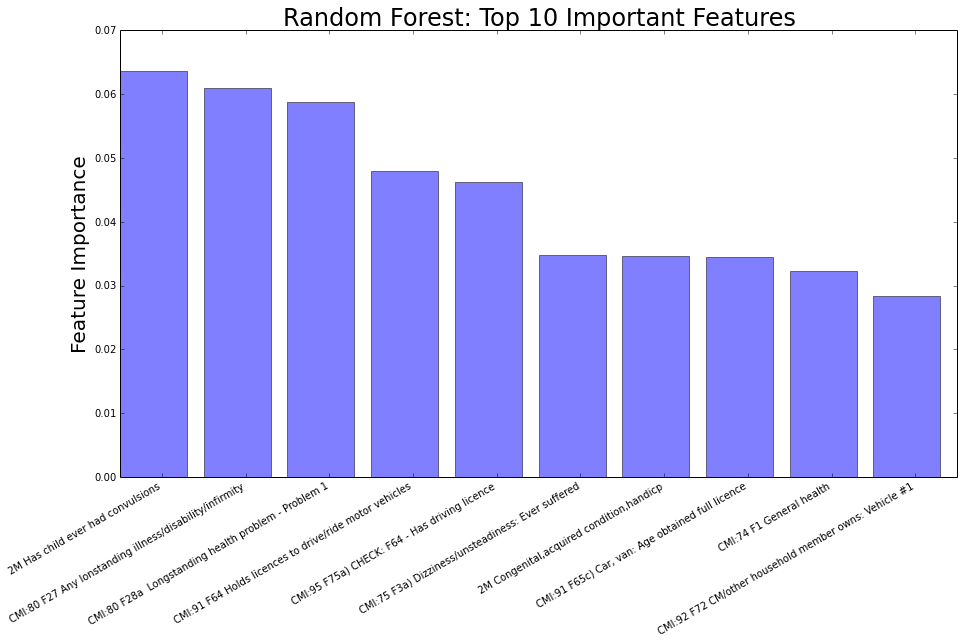

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))

n = 10
#Number of bars to use
indices = np.arange(n)
#Where to put the label under each bar
width = 0.5

top_n = [pair[1] for pair in pairs[:n]]
top_n_labels = [pair[0] for pair in pairs[:n]]

#Bar plot of the frequencies of the top words
ax.bar(indices, top_n, color='blue', alpha=0.5)

ax.set_ylabel('Feature Importance', size=20)
ax.set_title('Random Forest: Top ' + str(n) + " Important Features", size=24)

# #Label the bars with the top words
ax.set_xticks(indices + width)
ax.set_xticklabels(top_n_labels, size=14)

#Turn the labels sideways so they don't overlap
labels = ax.get_xticklabels()
plt.setp(labels, rotation=30, fontsize=10,ha = "right")

plt.savefig("Impor_featr_rf.png", format="png")
plt.show()
